# Практическая теория массового обслуживания для сисадминов

## Постановка задачи

В некой системе обработки видеороликов возникла потребность оценить будущую нагрузку и необходимость расширения ресурсов.


Чаще всего у веб-сайтов нагрузка зависит от множества факторов и попытки притянуть Теорию Массового Обслуживания (Queueing Theory в англоязычной литературе) слишком сложны, но для крупных заданий, вроде перекодирования видео, результаты близки к теоретическим и зависят почти только от длительности заданий.

 
## Данные 
В учебниках подобные расчеты выполняются на основе неких оценок распределений, но у нас есть возможность взять реальные данные видеопортала полученные при загрузке и обработке видеороликов. Эти данные находятся в файле videos.csv .
Чтобы обеспечить большой поток заявок, данные нужно "размножить" - провести процедуру выборки с возвратом.

## Библиотеки

Расчеты удобнее выполнять в языке R в виду наличия простых средств моделирования очередей.

Будем использовать специализированный пакет [queuecomputer](https://cran.r-project.org/web/packages/queuecomputer/index.html)



In [1]:
# Расскомментировать если потребуется установить библиотеку
# install.packages("queuecomputer")
library("queuecomputer")

## Настройки симулируемого процесса

- K -  число обработчиков-очередей. 
- λ (лямбда) - интенсивность потока. Среднее число заявок в единицу времени. Нужно измерить или установить на уровне предполагаемой нагрузки.

Производительность дополнительных ядер hyper-threading не поддается линейной оценке и поэтому K придется устанавливать без их учета.

In [2]:
K = 4 # число обработчиков-очередей

# 1/60 - в среднем 1 новый ролик  в 60 секунд.
lambda = 1/60

In [3]:
N <- 10000 # всего синтетических задач для симуляции

## Подготовка данных для симуляции

Данные о длительности используются как распределение длительностей обработки. Это еще не поток событий.

In [4]:
jobs <- read.csv(file="videos.csv")

Проконтролируем распределение времени выполнения задач визуально с помощью гистограммы:

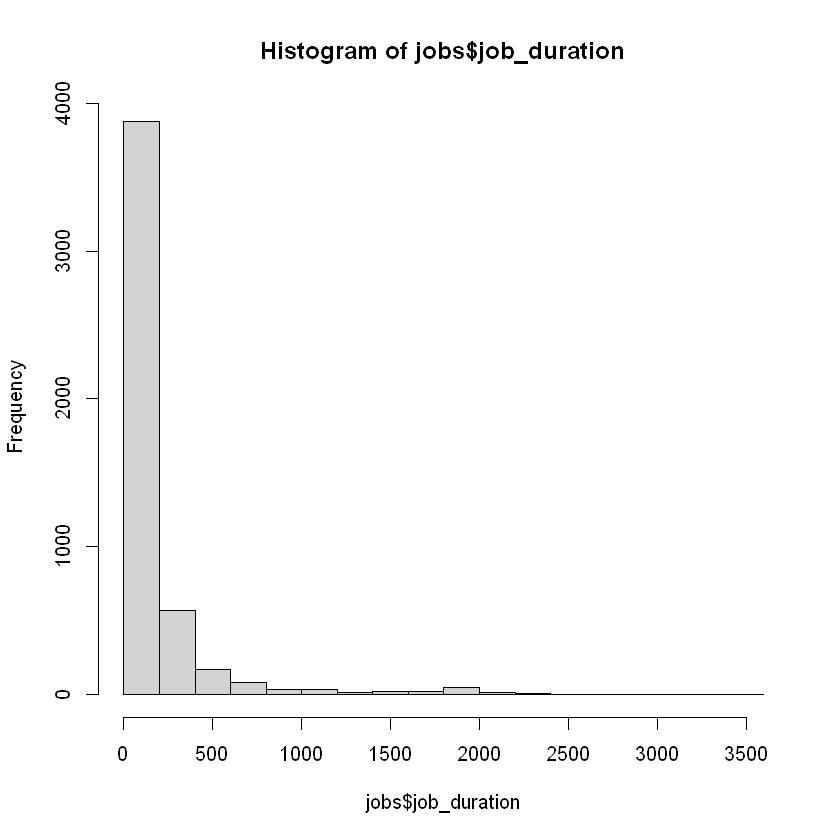

In [5]:
hist(jobs$job_duration)

Подготовка данных в формате который принимает пакет queuecomputer. 
Создадим выборку с возвратом.

In [6]:
service_times <- sample(jobs$job_duration,N,replace=TRUE)

Сформируем [Пуассоновский поток событий](https://ru.wikipedia.org/wiki/%D0%9F%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81_%D0%9F%D1%83%D0%B0%D1%81%D1%81%D0%BE%D0%BD%D0%B0). 

В этом случае времена между событиями  независимы и имеют экспоненциальное распределение.

In [12]:
inter_times = rexp(N, lambda) 
arrival_times <- cumsum(inter_times)

## Непосредственно  расчеты
Mean waiting time - среднее время ожидания.
summary показывает текстовую сводку.

Нужно обратить внимание на utilization factor.

In [8]:
queue_obj <- queue_step(arrival_times, service_times, servers = K)
summary(queue_obj)

Total customers:
 10000
Missed customers:
 0
Mean waiting time:
 174
Mean response time:
 352
Utilization factor:
 0.736095482028415
Mean queue length:
 2.9
Mean number of customers in system:
 5.84

график вероятностей ожидания

system time - это ожидание + обработка

[[1]]


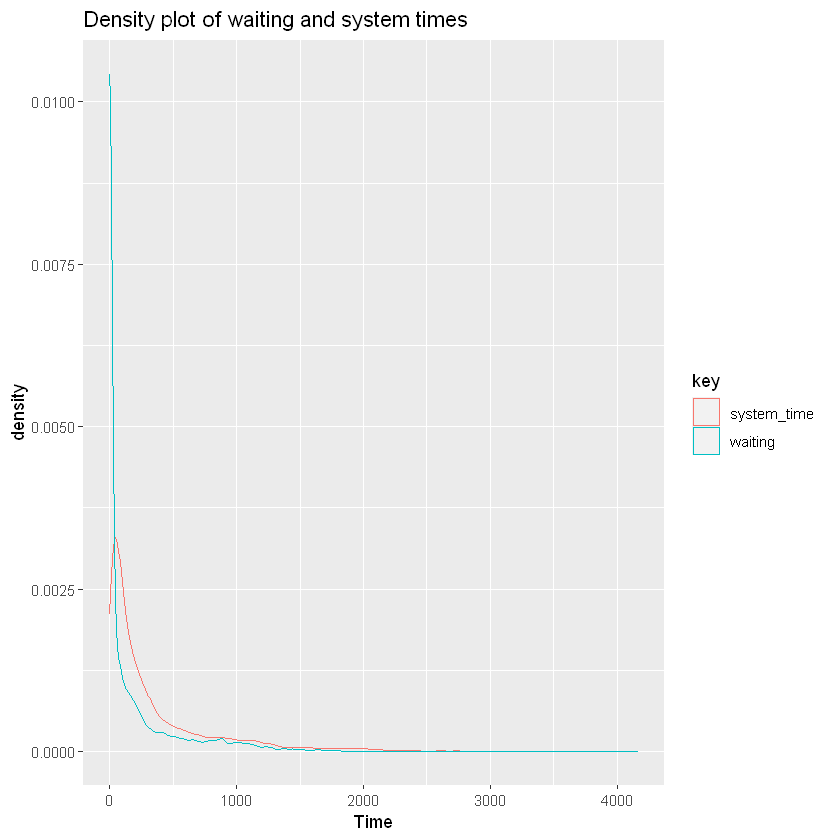

In [9]:
plot(queue_obj,which=3)

## Расчет качества

Выберем порог времени ожидания, после которого пользователь уходит с сайта, что считается недопустимым для сервиса.

In [10]:
threshold <- 15*60 # порог в секундах

Рассчитаем вероятность того, что отдельно взятый клиент встретится с недопустимым ожиданием в очереди.  Просто используем все рассчитанные случаи загрузки как отдельные независимые события.

Вероятность должна быть достаточно маленькой с практической точки зрения. В этом случае подбор параметра K считается удовлетворяющим требования.

In [11]:
sum(queue_obj$departures_df$waiting > threshold) /length(queue_obj$departures_df$waiting)

[1] 0.0565

## Современный взгляд на проблему
 Не стоит забывать, что для современных облачных архитектур затраты на подключение новых обработчиков околонулевые и поэтому лучше выбрать динамическое создание серверов. 